In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpig
import numpy as np
import torch

In [34]:
img_mpig = mpig.imread("./img/img.jpg")
# img_mpig = img_mpig[:, :, 0]
print("img:", img_mpig.shape)

img: (977, 1440, 3)


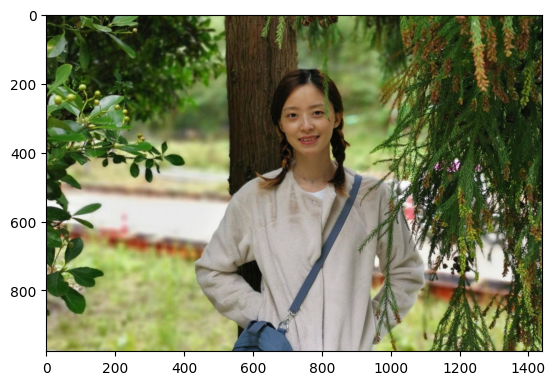

In [35]:
dataset = torch.Tensor(img_mpig).float()
plt.imshow(dataset / 255.0)

In [47]:
# 确定超参数的值
num_steps = 5000 # 对于步骤，一开始可以有beta、分布的均值和标准差来共同确定
# 制定每一步的beta
# betas是一个按照时间从小到大变化的，这样才可以假设每一个逆扩散过程是一个马尔可夫过程
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

# 计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape

print("all the same shape:", betas.shape)

all the same shape: torch.Size([5000])


### 3. 确定扩散过程任意时刻的采样值

In [48]:
# 计算任意时刻的x的采样值，基于x_0和参数重整化技巧

def q_x(x_0, t):
    '''可以基于x[0]得到任意时刻t的x[t]'''
    noise = torch.randn_like(x_0) # noise是从正态分布中生成的随机噪声
#     print("noise:{}".format(noise))
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声

### 4.演示原始分布加噪100次后的结果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

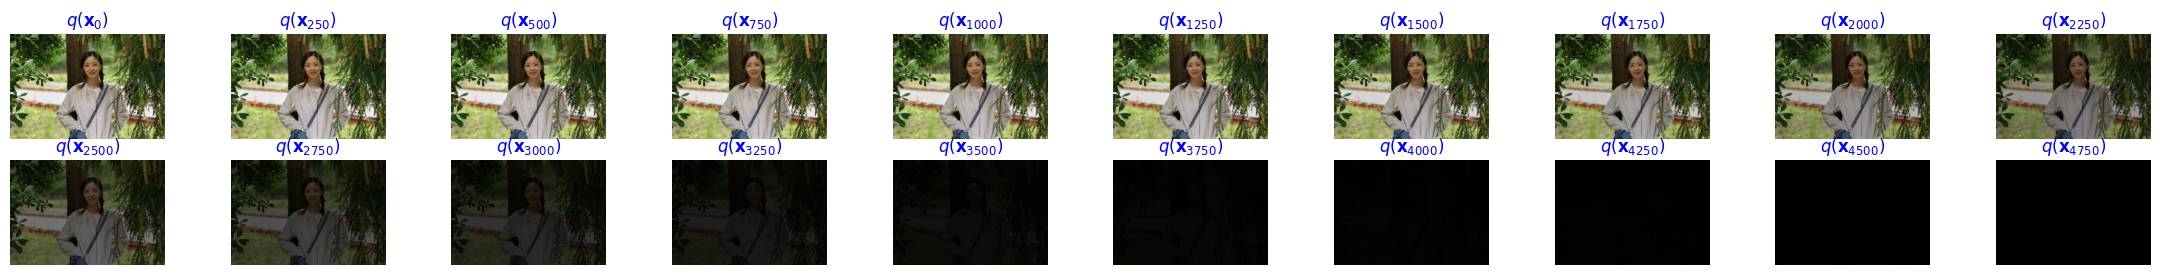

In [49]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize = (28, 3))
plt.rc('text', color='blue')

# 共有10000个点，每个点包含两个坐标
# 生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_shows])) # 生成t时刻的采样数据
#     print("第{}次加噪".format(i))
#     print(q_i)
    axs[j, k].imshow(q_i / 255.0)
    axs[j ,k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i * num_steps // num_shows)+'})$')
    

### 5. 编写逆扩散过程高斯分布模型

In [50]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        
        )
        
        self.step_embeddings = nn.ModuleList([
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
        ])
        
        
        
        
    def forward(self, x_0, t):
        
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)
        
        x = self.linears[-1](x)
        
        return x
        
        

In [51]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    '''对任意时刻t进行采样计算loss'''
    
    
    batch_size = x_0.shape[0]
    # 随机采样一个时刻t，为了提高训练效率，这里确保t不重复 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)
    t = t.unsqueeze(-1)
    
    # x0的系数
    a = alphas_bar_sqrt[t]
    
    # eps的系数
    am1 = one_minus_alphas_bar_sqrt[t]
    
    # 生成随机噪声eps
    e = torch.randn_like(x_0)
    
    # 构建模型输入
    x = x_0 * a + e * am1
    
    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))
    
    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

In [52]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alpahs_bar_sqrt):
    '''从x[T]恢复x[T-1]、x[T-2]、...、x[0]'''
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
        
    return x_seq


def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    '''从x[T]采样t时刻的重构值'''
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x, t)
    
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)



### 3. 确定扩散过程任意时刻的采样值

In [53]:
seed = 1234
class EMA():
    '''构建一个参数平滑器'''
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self, name, val):
        self.shadow[name] = val.clone()
        
    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print('Traning model...')

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 1000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[i - 1].set_axis_off()
            axs[i - 1].set_title('$q(\mathbf{x}_{'+str(i * 10)+'})$')

Traning model...


RuntimeError: The size of tensor a (1440) must match the size of tensor b (128) at non-singleton dimension 1

### 4.演示原始分布加噪100次后的结果

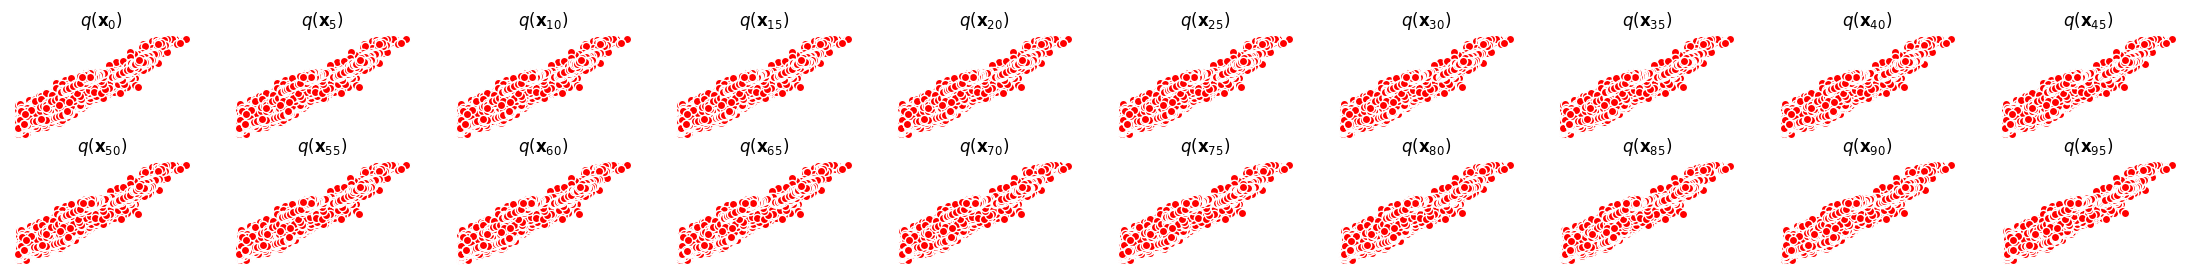